<p>The data comes from https://www.kaggle.com/kazanova/sentiment140</p>

[1. Imports](#1)
<br></br>
[2. BERT](#2)
<br></br>
[3. Random Forest | Logistics Regression | MultinomialNB](#3)
<br></br>
[4. Compare the results](#4)

<span id = "1"></span>
# Imports

In [ ]:
#import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [ ]:
df.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# 0 negative; 4 positive
df.target.unique()

array([0, 4])

<AxesSubplot:xlabel='target', ylabel='count'>

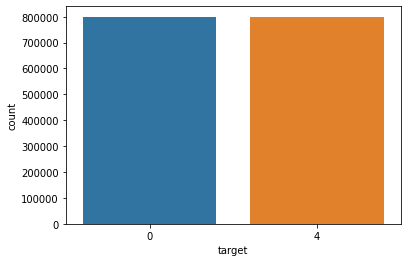

In [ ]:
sns.countplot(x=df['target'], data = df)

In [ ]:
# The dataset is very large, so I take 5%.
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=23)

In [ ]:
# Define func for cleaning text
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)              # remove all letters and numbers after @ sign, in sentence (text)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)    # remove urls, http and https, many times as need it
  tweet = re.sub(r"[^A-za-z.!?']", ' ', tweet)              # remove chars that are not AZ,az, !?'
  tweet = re.sub(r" +", ' ', tweet)                         # replace white spaces (at least two or more) to one white space
  return tweet

In [ ]:
# Apply func to a text
sampleDf['text'] = sampleDf['text'].map(clean_tweet)

In [ ]:
# Check a head again (cleaned)
sampleDf.head(5)

,target,id,date,flag,user,text
1055148,4,1962159448,Fri May 29 10:36:54 PDT 2009,NO_QUERY,starchild24,yesterday was a fun day i love my work.
205169,0,1972807026,Sat May 30 09:55:30 PDT 2009,NO_QUERY,soundkitchen,SWFWheel ???? js ? ExternalInterface ?????????...
214746,0,1975307423,Sat May 30 14:53:05 PDT 2009,NO_QUERY,Desibeez,I COULD OF SWORN IT WAS OTOWN UGH I SUCK! I'm...
367135,0,2049116589,Fri Jun 05 16:19:26 PDT 2009,NO_QUERY,ryanwalker19,awwww maddy has gone
985037,4,1834438053,Mon May 18 02:56:10 PDT 2009,NO_QUERY,_nataliee,i guess i should feel special that alfie nearl...


<span id = "2"></span>
# BERT

In [ ]:
# Set x and y and split the data
x = sampleDf.text.values
y = sampleDf.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
# We could get away with other approach but we might want to use this for more than binary classification (in other projects).
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
# Check the data length
print(len(x_train))
print(len(y_train))
print(len(y_test))
print(len(x_test))

64000
64000
16000
16000


In [ ]:
# Set a bert layer - bert model
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

# vocab_file reads the vocab file associated to the downloaded model.
# do_lower_case reads binary variable which if True means tokenizer will reformat all text to lower case rendering model to be NOT case sensitive. 
# tokenizer builds tokenizer using variables vocab_file and do_lower_case

In [ ]:
# Define a func which add [SEP] = 102 on the end of tweet, then tokenize tweet
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)


# Constructs a constant RaggedTensor from a nested Python list.
tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
# Check first tweet: text format and tokenized format with SEP
print(x_train[0] + '\n')
print(tweets[0])

I FOUND OUT THAT THEY PAY THE WHITE CHICK MORE THAN ME WHY?? I DONT KNOW!!! WHAT SHOULD I DO???

tf.Tensor(
[   146    143  11403  69849  11490    152  65729    157  58132  11090
  17443  14703  32349  14703  17443    160 108880  29833  39774  30889
  11733 102059  66014    157  58132  11537  47430    160  12396  14703
    136    136    146  99843  77261    148  67292  13034    106    106
    106    160  58132  11090  38702  11403 100673  11490    146  99843
    136    136    136    102], shape=(54,), dtype=int32)


In [ ]:
# Create list of tokenized [CLS]: length of list = length of x_train
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]

# Concat cls list with tweets tensor
input_word_ids = tf.concat([cls, tweets], axis=-1)

In [ ]:
# Check first tweet: text format and tokenized format with CLS and SEP
print(x_train[0] + '\n')
print(input_word_ids[0])

I FOUND OUT THAT THEY PAY THE WHITE CHICK MORE THAN ME WHY?? I DONT KNOW!!! WHAT SHOULD I DO???

tf.Tensor(
[   101    146    143  11403  69849  11490    152  65729    157  58132
  11090  17443  14703  32349  14703  17443    160 108880  29833  39774
  30889  11733 102059  66014    157  58132  11537  47430    160  12396
  14703    136    136    146  99843  77261    148  67292  13034    106
    106    106    160  58132  11090  38702  11403 100673  11490    146
  99843    136    136    136    102], shape=(55,), dtype=int32)


In [ ]:
# The model expects two additional inputs:

# The input mask
# The input type

# The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.
input_mask = tf.ones_like(input_word_ids).to_tensor()

# Crate Tensor with 0s ([CLS])
type_cls = tf.zeros_like(cls)
# Crate Tensor with 1s (words and [SEP])
type_tweet = tf.ones_like(tweets)

# Concat type_cls, type_tweet
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

In [ ]:
print("We have 32 tokens in first tweet including [CLS] and [SEP]\n")
print(input_word_ids[0])
print('\n')
print("We created mask where we have 1s. Exactly as many tokens. Shape is 117, because that's the longest tokenized tweet.\n")
print(input_mask[0])
print('\n')
print("Tensor with 0s ([CLS])\n")
print(type_cls[0])
print('\n')
print("Tensor with 1s (words and [SEP])\n")
print(type_tweet[0])
print('\n')
print("Concataned type_cls, type_tweet")
print("First token [CLS] is 0 rest of tokens are 1s + possible padding = 0\n")
print(input_type_ids[0])
print('\nShapes:')
print('input_word_ids:', input_word_ids.shape)
print('input_mask:', input_mask.shape)
print('input_type_ids:', input_type_ids.shape)

We have 32 tokens in first tweet including [CLS] and [SEP]

tf.Tensor(
[   101    146    143  11403  69849  11490    152  65729    157  58132
  11090  17443  14703  32349  14703  17443    160 108880  29833  39774
  30889  11733 102059  66014    157  58132  11537  47430    160  12396
  14703    136    136    146  99843  77261    148  67292  13034    106
    106    106    160  58132  11090  38702  11403 100673  11490    146
  99843    136    136    136    102], shape=(55,), dtype=int32)


We created mask where we have 1s. Exactly as many tokens. Shape is 117, because that's the longest tokenized tweet.

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0], shape=(117,), dtype=int32)


Tensor with 0s ([CLS])

tf.Tensor([0], shape=(1,), dtype=int32)


Tensor with 1s (words and [SEP])

tf.Tensor(


In [ ]:
# Create list of lengths for every tweet
lens = [len(i) for i in input_word_ids]

In [ ]:
# Check the max length 
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

# We can add a bit more to the max_seq_length esspecially when ussing just a fraction of data.
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 117
Max length is: 175


In [ ]:
# bert encode func
# main func it contains encode_names func and all what was showed earlier
    # func returns dict input_word_ids, input_mask, input_type_ids

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
# Apply main func to x_train, x_test data
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
print(X_train['input_word_ids'][0])
print(X_train['input_mask'][0])
print(X_train['input_type_ids'][0])

tf.Tensor(
[   101    146    143  11403  69849  11490    152  65729    157  58132
  11090  17443  14703  32349  14703  17443    160 108880  29833  39774
  30889  11733 102059  66014    157  58132  11537  47430    160  12396
  14703    136    136    146  99843  77261    148  67292  13034    106
    106    106    160  58132  11090  38702  11403 100673  11490    146
  99843    136    136    136    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0   

In [ ]:
# BERT MODEL

num_class = 2  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)



model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

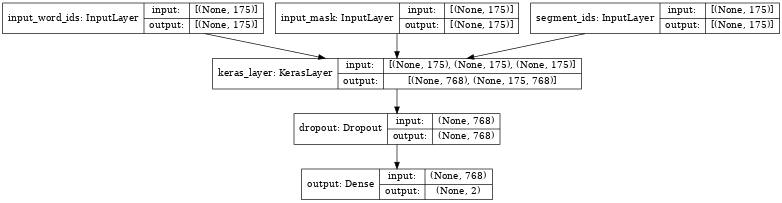

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size) # used to lower the learning rate in order to reduce the impact of deviating the model from learning on sudden new data set exposure.

# Create optimizer
optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 175)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 175)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 175)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4000/4000 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.6302WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc69c2d3c20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4000/4000 [==============================] - 1686s 416ms/step - loss: 0.6264 - 

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.8235
Testing Accuracy:  0.8010


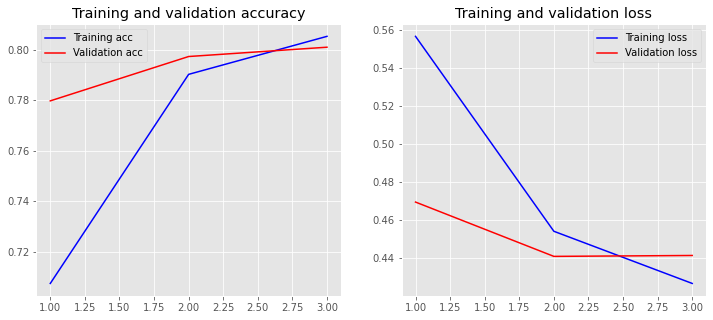

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

<span id = "3"></span>
# Random Forest | Logistics Regression | MultinomialNB

In [ ]:
# making a dictionary in which we include three models with some parameters pre-set.
model_params = {
    'random_forest' :{
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [1, 5, 10, 100]
        }
    },
    
    'logistics_regression' :{
        'model' : LogisticRegression(solver = 'lbfgs', multi_class = 'auto'),
        'params' : {
            'C' : [0.1, 1, 10, 100],
            'solver' : ['lbfgs', 'liblinear']
        }
    },

    'MultinomialNB' :{
        'model' : MultinomialNB(),
        'params' : {
            'alpha' : np.linspace(0.5, 1.5, 6),
            'fit_prior' : [True, False]
        }
    }
}

In [ ]:
# Convert a collection of text documents to a matrix of token counts using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x)

X = vectorizer.transform(x)

In [ ]:
# Split the data again, but our X is now vectorizered. random_state is the same
X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.2, random_state=32)

In [ ]:
# implement GridSearchCV for three models using a loop and a previously created dictionary
# in the created variable scores, we save best_score and best_params for each model
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1)
    print(mp['model'])
    print('\nfitting...')
    clf.fit(X, y)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    print('\nscore is appended\n')

RandomForestClassifier()

fitting...

score is appended

LogisticRegression()

fitting...

score is appended

MultinomialNB()

fitting...

score is appended



In [ ]:
# making data frame with best scores and best params
sc = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
sc

,model,best_score,best_params
0,random_forest,0.764700,{'n_estimators': 100}
1,logistics_regression,0.774850,"{'C': 0.1, 'solver': 'liblinear'}"
2,MultinomialNB,0.765175,"{'alpha': 1.5, 'fit_prior': False}"


In [ ]:
# implementing logistics regression model with best_params
clf_lr = LogisticRegression(solver = 'liblinear', C = 0.1)
clf_lr.fit(X_train, Y_train)

LogisticRegression(C=0.1, solver='liblinear')

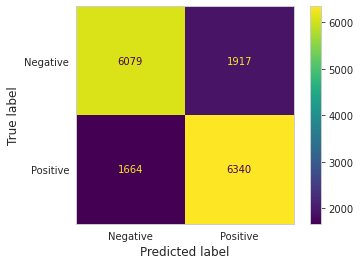

In [ ]:
# confusion matrix LR
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(clf_lr,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels=['Negative', 'Positive'])

In [ ]:
# Create a classification report for the LR model 
predictions_lr = clf_lr.predict(X_test)

# Create a classification report for the LR model 
print(classification_report(Y_test,predictions_lr))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      7996
           4       0.77      0.79      0.78      8004

    accuracy                           0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000



<span id = "4"></span>
# Compare the results

## 1. BERT:                 80%
## 2. Logistics Regression: 78%

<p>First we have to remember that we use 5% of the 1.6 million tweets in this project</p>
<p>BERT was 80% accuracy, and Logistics Regression 78%. We have to answer ourselves whether 2% is a lot for a given project / data set. Here we can see that it will be a better choice to use Logistics Regression because we can achieve this result much faster compared to BERT where training lasted 1h 20min on the GPU kaggle. </p>